Reading the Dataset

In [2]:
!pip3 install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.2.2-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [1]:

import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.12.0', '1.23.5')

In [4]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)
ROOT = 'dataset'
def read_image(path):
    image_1 = cv2.imread(path)
    image = cv2.resize(image_1, (128, 128))

    if image is not None:
        return image
    else:
        print(f"Error: Unable to load image at path {path}")
        return None


In [5]:
# def split_dataset(directory, split=0.9):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)

#     random.shuffle(folders)

#     train_list, test_list = {}, {}

#     # Creating Train-list
#     for folder in folders:
#       print(folder)
#       if os.path.isdir(f"{directory}/{folder}"):
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files

#     # Creating Test-list
#     for folder in folders:
#       if os.path.isdir(f"{directory}/{folder}"):
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files
#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.9)
# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTrain List:", train_list)
# print("\nTest List:", test_list)

Creating Triplets

In [6]:
# def create_triplets(directory, folder_list, max_files, data_type):
#     triplets = []
#     folders = os.listdir(directory)

#     for folder in folders:
#       path = os.path.join(directory, folder)
#       files = list(os.listdir(path))
#       num_files = int(len(files) * 0.9)

#       for i in range(num_files-1):
#         for j in range(i+1, num_files):
#           anchor = (folder, files[i])
#           # print(anchor)
#           positive = (folder, files[i])

#           neg_folder = folder
#           while neg_folder == folder:
#             neg_folder = random.choice(folders)

#           path = os.path.join(directory, neg_folder)
#           files = list(os.listdir(path))
#           neg_file = random.randint(0, folder_list[neg_folder]-1)
#           negative = (neg_folder, files[neg_file])
#           triplets.append((anchor, positive, negative))
#     random.shuffle(triplets)
#     return triplets


In [70]:
import os
import random

def create_triplets(directory, img_per_class=None):
    triplets = []
    folders = os.listdir(directory)
    try:
        folders.remove(".DS_Store")
    except ValueError:
        pass
    for folder in folders[:50]:

        path = os.path.join(directory, folder)
        files = os.listdir(path)
        try:
            files.remove(".DS_Store")
        except ValueError:
            pass
        

        # Creating training triplets
        for anchor_file in files[:img_per_class]:
            positive_file = random.choice([file for file in files if file != anchor_file])
            negative_folder = random.choice([f for f in folders[:10] if f != folder])
            negative_images = os.listdir(os.path.join(directory, negative_folder))
            try:
                negative_images.remove(".DS_Store")
            except ValueError:
                pass
            negative_file = random.choice(negative_images)
            triplets.append(((folder, anchor_file), (folder, positive_file), (negative_folder, negative_file)))

    random.shuffle(triplets)

    return triplets

# Example usage
train_triplet = create_triplets("dataset/train", 50)
test_triplet = create_triplets("dataset/test")
validation_triplet = create_triplets("dataset/validation", 10)
# train_triplet.extend(validation_triplet)


In [11]:
# train_triplet = create_triplets(ROOT, train_list, 0.9, 'train')
# test_triplet  = create_triplets(ROOT, test_list, 0.1, 'test')

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
print("Number of testing triplets :", len(validation_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 2497
Number of testing triplets : 2130
Number of testing triplets : 500

Examples of triplets:
(('pins_Jason Momoa', 'Jason Momoa18_2464.jpg'), ('pins_Jason Momoa', 'Jason Momoa189_2474.jpg'), ('pins_Chris Pratt', 'Chris Pratt142_762.jpg'))
(('pins_Brian J. Smith', 'Brian J. Smith6_698.jpg'), ('pins_Brian J. Smith', 'Brian J. Smith239_673.jpg'), ('pins_Mark Zuckerberg', 'Mark Zuckerberg214_2037.jpg'))
(('pins_Emma Stone', 'Emma Stone68_1812.jpg'), ('pins_Emma Stone', 'Emma Stone54_1797.jpg'), ('pins_Logan Lerman', 'Logan Lerman166_2341.jpg'))
(('pins_Richard Harmon', 'Richard Harmon66_634.jpg'), ('pins_Richard Harmon', 'Richard Harmon65_633.jpg'), ('pins_Pedro Alonso', 'Pedro Alonso29_2166.jpg'))
(('pins_Ben Affleck', 'Ben Affleck100_121.jpg'), ('pins_Ben Affleck', 'Ben Affleck10_120.jpg'), ('pins_Avril Lavigne', 'Avril Lavigne134_588.jpg'))


Creating Batch-Generator

In [12]:
def get_batch(triplet_list, data_type, batch_size=4, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            # print(f'dataset/{type}/{a[0]}/{a[1]}')
            anchor.append(read_image(f'dataset/{data_type}/{a[0]}/{a[1]}'))
            positive.append(read_image(f'dataset/{data_type}/{p[0]}/{p[1]}'))
            negative.append(read_image(f'dataset/{data_type}/{n[0]}/{n[1]}'))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

Plotting the Data

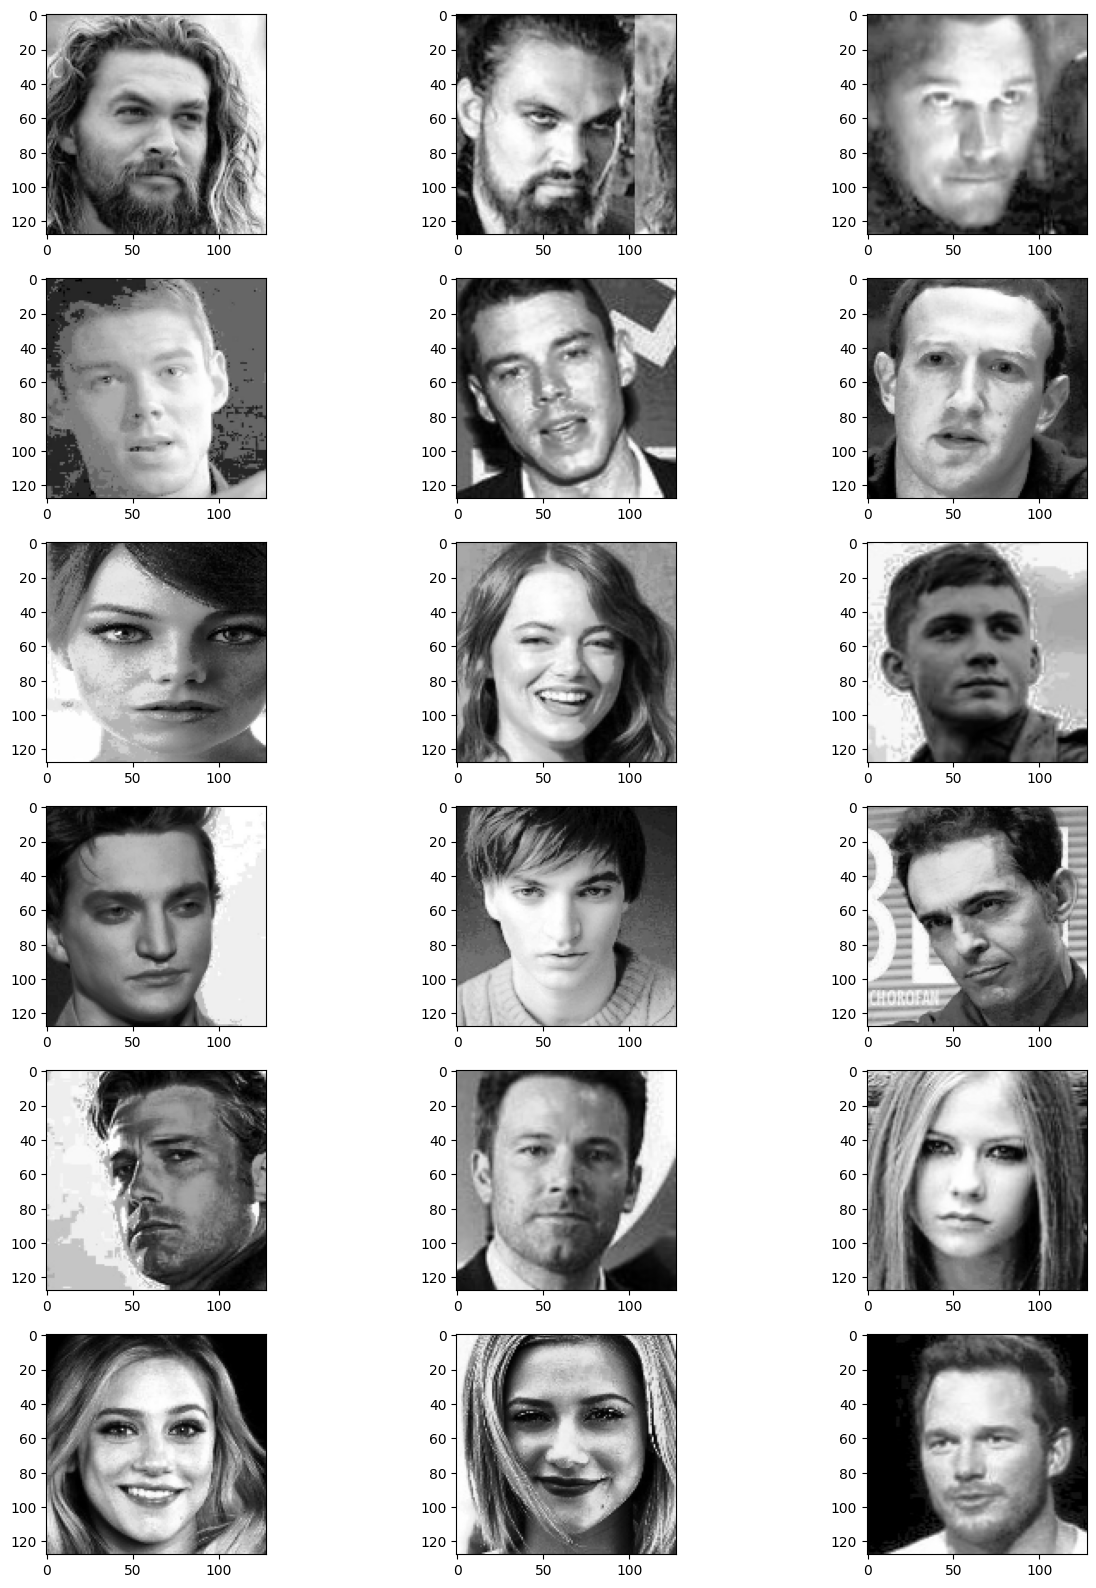

In [13]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, "train", batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [11]:
# num_plots = 6

# f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

# for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
#     a,p,n = x
#     for i in range(num_plots):
#         axes[i, 0].imshow(a[i])
#         axes[i, 1].imshow(p[i])
#         axes[i, 2].imshow(n[i])
#         i+=1
#     break

Creating the Model

In [14]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2


from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Encoder

In [38]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    print(len(pretrained_model.layers))

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),

        layers.BatchNormalization(),
        layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),

        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")

    print(len(encode_model.layers))
    return encode_model

Siamese Network

In [39]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

133
8
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                            

In [28]:

class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [29]:
siamese_model = SiameseModel(siamese_network)

# optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
# siamese_model.compile(optimizer=optimizer)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
siamese_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the Model

In [30]:
def test_on_triplets(batch_size = 4):
    pos_scores, neg_scores = [], []

    for data in get_batch(validation_triplet, 'validation',batch_size=batch_size):
        prediction = siamese_model.predict(data)
        # print(prediction)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on validation = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [31]:
save_all = False
epochs = 50
batch_size = 16

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    print(epoch)
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    i = 0
    for data in get_batch(train_triplet, "train", batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
        print(f"itr: {i}")
        i += 1
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy


1
itr: 0
itr: 1
itr: 2
itr: 3
itr: 4
itr: 5
itr: 6
itr: 7
itr: 8
itr: 9
itr: 10
itr: 11
itr: 12
itr: 13
itr: 14
itr: 15
itr: 16
itr: 17
itr: 18
itr: 19
itr: 20
itr: 21
itr: 22
itr: 23
itr: 24
itr: 25
itr: 26
itr: 27
itr: 28
itr: 29
itr: 30
itr: 31
itr: 32
itr: 33
itr: 34
itr: 35
itr: 36
itr: 37
itr: 38
itr: 39
itr: 40
itr: 41
itr: 42
itr: 43
itr: 44
itr: 45
itr: 46
itr: 47
itr: 48
itr: 49
itr: 50
itr: 51
itr: 52
itr: 53
itr: 54
itr: 55
itr: 56
itr: 57
itr: 58
itr: 59
itr: 60
itr: 61
itr: 62
itr: 63
itr: 64
itr: 65
itr: 66
itr: 67
itr: 68
itr: 69
itr: 70
itr: 71
itr: 72
itr: 73
itr: 74
itr: 75
itr: 76
itr: 77
itr: 78
itr: 79
itr: 80
itr: 81
itr: 82
itr: 83
itr: 84
itr: 85
itr: 86
itr: 87
itr: 88
itr: 89
itr: 90
itr: 91
itr: 92
itr: 93
itr: 94
itr: 95
itr: 96
itr: 97
itr: 98
itr: 99
itr: 100
itr: 101
itr: 102
itr: 103
itr: 104
itr: 105
itr: 106
itr: 107
itr: 108
itr: 109
itr: 110
itr: 111
itr: 112
itr: 113
itr: 114
itr: 115
itr: 116
itr: 117
itr: 118
itr: 119
itr: 120
itr: 121
itr: 122
i

In [32]:
# Save the weights of the Siamese model
siamese_model.save_weights(f"Recognition_siamese_model_final")

Evaluating the Model

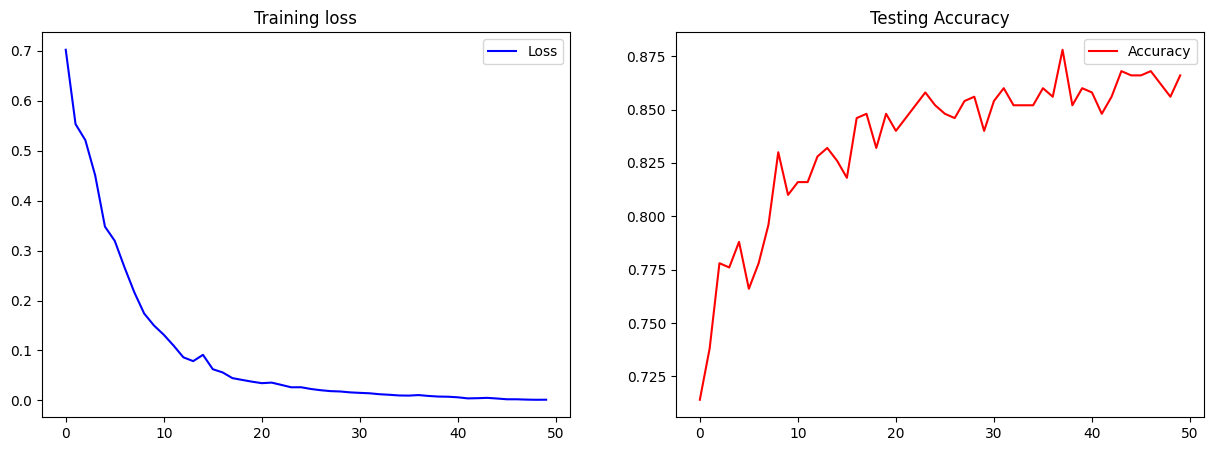

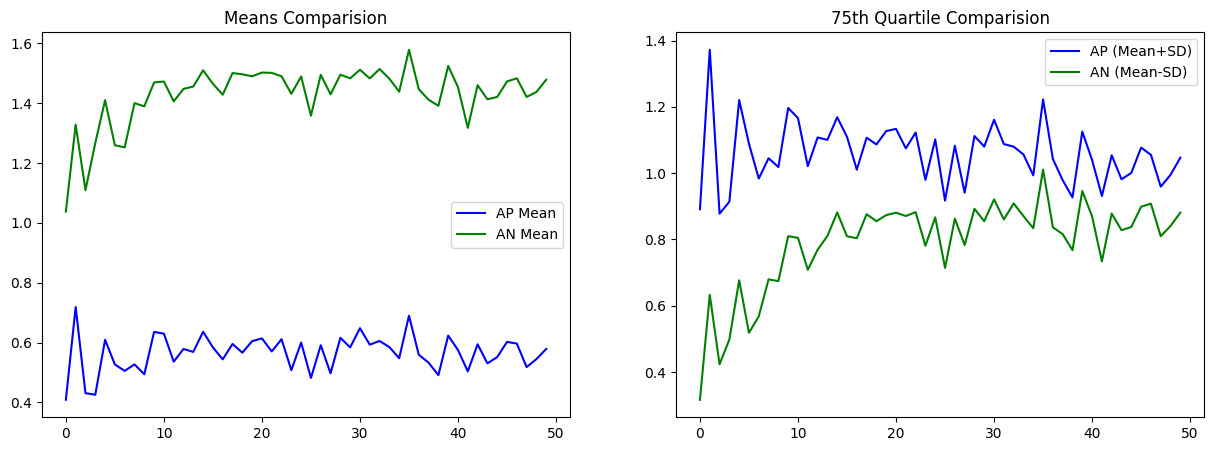

In [34]:
#from keras.models import Model, load_model
#final_model = load_model(f"{parent_folder}/siamese_model.h5")
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

Using the Model

In [42]:
best_acc_model = SiameseModel(siamese_network)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)

best_acc_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Path to the saved weights
weights_path = "siamese_model"

# Load the previously saved weights
best_acc_model.load_weights(weights_path)

print("Weights loaded successfully.")

Weights loaded successfully.


In [47]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

133
8
Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_29 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                

Classify Images

In [48]:
def classify_images(face_list1, face_list2, threshold=1.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

1/1 [==============================] - 0s 48ms/step

Accuracy of model: 0.7776995305164319



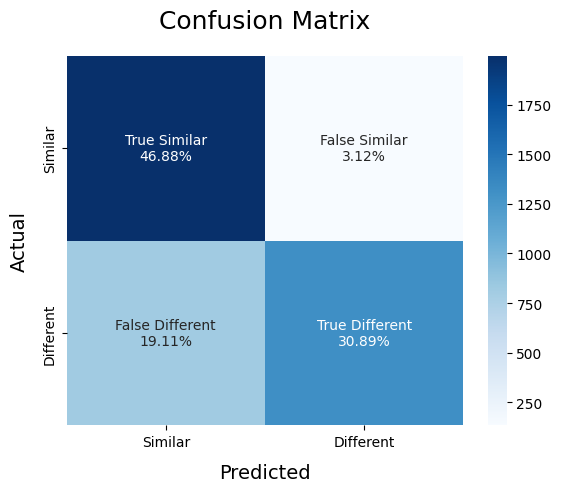

In [49]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet,"test", batch_size=4):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))


ModelMetrics(pos_list, neg_list)

In [53]:
import os
import shutil
import random

def split_data(source_dir, train_dir, test_dir, split_ratio=0.5):
    # Ensure the train and test directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Traverse each subfolder in the source directory
    for subdir, _, files in os.walk(source_dir):
        if not files:
            continue
        # Create corresponding subdirectories in train and test folders
        relative_subdir = os.path.relpath(subdir, source_dir)
        train_subdir = os.path.join(train_dir, relative_subdir)
        test_subdir = os.path.join(test_dir, relative_subdir)
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Shuffle files and split into train and test sets
        random.shuffle(files)
        split_point = int(len(files) * split_ratio)
        train_files = files[:split_point]
        test_files = files[split_point:]

        # Copy files to the train and test directories
        for file in train_files:
            src_file = os.path.join(subdir, file)
            dst_file = os.path.join(train_subdir, file)
            shutil.copy2(src_file, dst_file)

        for file in test_files:
            src_file = os.path.join(subdir, file)
            dst_file = os.path.join(test_subdir, file)
            shutil.copy2(src_file, dst_file)

# Define paths
source_directory = 'faces'
train_directory = 'faces_ds/validation'
test_directory = 'faces_ds/test'

# shutil.rmtree(train_directory)
# shutil.rmtree(test_directory)

# Split the data
split_data(source_directory, train_directory, test_directory, split_ratio=0.7)

print("Data split completed!")

Data split completed!


In [71]:
# Example usage
train_triplet = create_triplets("faces_ds/train")
validation_triplet = create_triplets("faces_ds/validation")
# validation_triplet = create_triplets("dataset/validation", 10)
# train_triplet.extend(validation_triplet)

print(len(train_triplet))
print(len(validation_triplet))

446
193


In [74]:
def get_custom_batch(triplet_list, data_type, batch_size=4, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            # print(a,p,n)
            anchor.append(read_image(f'faces_ds/{data_type}/{a[0]}/{a[1]}'))
            positive.append(read_image(f'faces_ds/{data_type}/{p[0]}/{p[1]}'))
            negative.append(read_image(f'faces_ds/{data_type}/{n[0]}/{n[1]}'))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

In [73]:
def test_on_triplets(batch_size = 4):
    pos_scores, neg_scores = [], []

    for data in get_custom_batch(validation_triplet, 'validation',batch_size=batch_size):
        prediction = siamese_model.predict(data)
        # print(prediction)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on validation = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [75]:
save_all = False
epochs = 20
batch_size = 4

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    print(epoch)
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    i = 0
    for data in get_custom_batch(train_triplet, "train", batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
        print(f"itr: {i}")
        i += 1

    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights(f"siamese_model_custom_{epoch}")
        max_acc = accuracy


1
itr: 0
itr: 1
itr: 2
itr: 3
itr: 4
itr: 5
itr: 6
itr: 7
itr: 8
itr: 9
itr: 10
itr: 11
itr: 12
itr: 13
itr: 14
itr: 15
itr: 16
itr: 17
itr: 18
itr: 19
itr: 20
itr: 21
itr: 22
itr: 23
itr: 24
itr: 25
itr: 26
itr: 27
itr: 28
itr: 29
itr: 30
itr: 31
itr: 32
itr: 33
itr: 34
itr: 35
itr: 36
itr: 37
itr: 38
itr: 39
itr: 40
itr: 41
itr: 42
itr: 43
itr: 44
itr: 45
itr: 46
itr: 47
itr: 48
itr: 49
itr: 50
itr: 51
itr: 52
itr: 53
itr: 54
itr: 55
itr: 56
itr: 57
itr: 58
itr: 59
itr: 60
itr: 61
itr: 62
itr: 63
itr: 64
itr: 65
itr: 66
itr: 67
itr: 68
itr: 69
itr: 70
itr: 71
itr: 72
itr: 73
itr: 74
itr: 75
itr: 76
itr: 77
itr: 78
itr: 79
itr: 80
itr: 81
itr: 82
itr: 83
itr: 84
itr: 85
itr: 86
itr: 87
itr: 88
itr: 89
itr: 90
itr: 91
itr: 92
itr: 93
itr: 94
itr: 95
itr: 96
itr: 97
itr: 98
itr: 99
itr: 100
itr: 101
itr: 102
itr: 103
itr: 104
itr: 105
itr: 106
itr: 107
itr: 108
itr: 109
itr: 110
itr: 111

EPOCH: 1 	 (Epoch done in 19 sec)
Loss on train    = 0.99996
1/1 [==============================] -

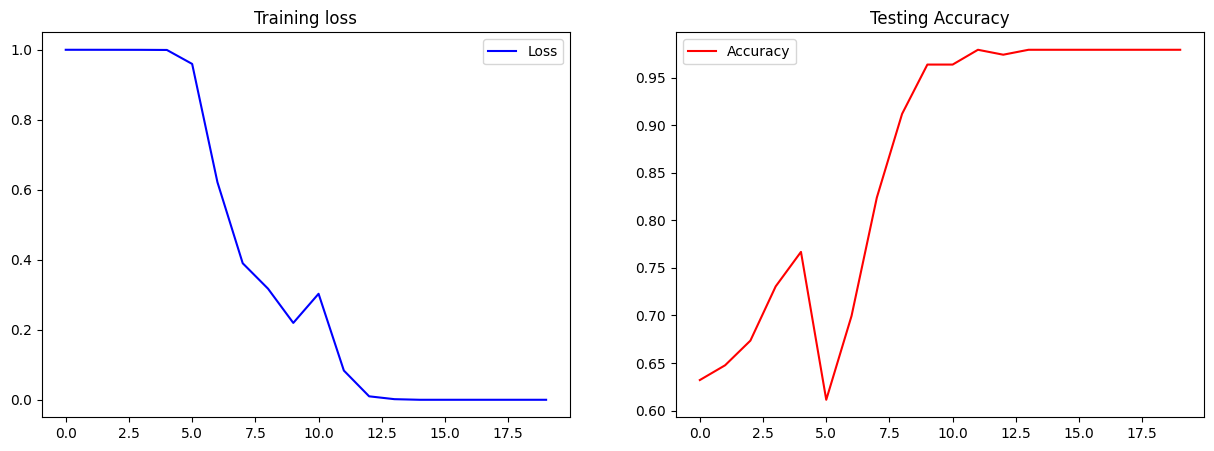

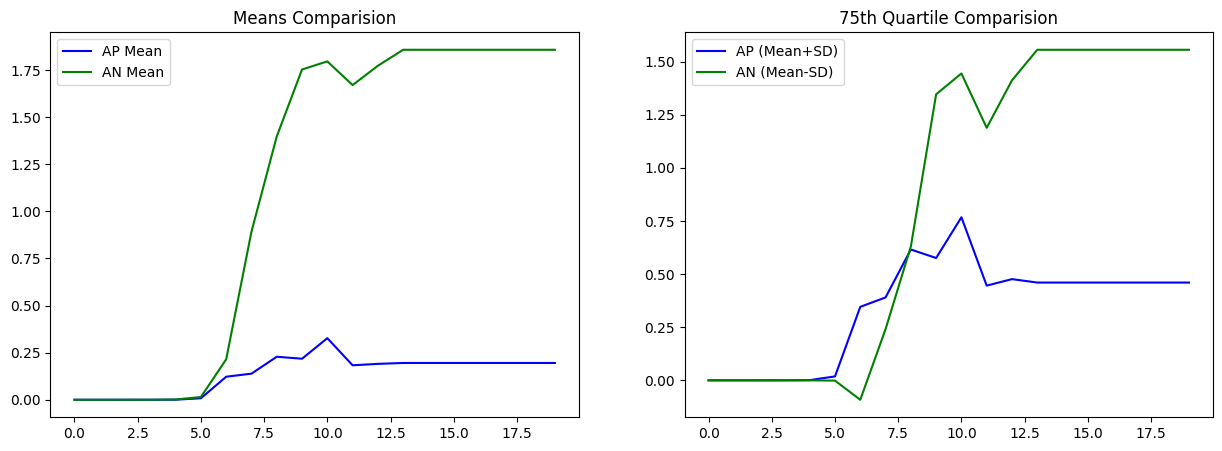

In [76]:
test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

1/1 [==============================] - 0s 39ms/step

Accuracy of model: 0.4896373056994819



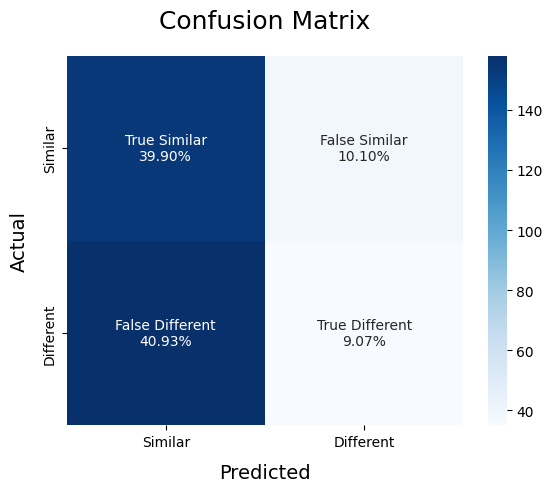

In [77]:
pos_list = np.array([])
neg_list = np.array([])

for data in get_custom_batch(validation_triplet,"validation", batch_size=4):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))


ModelMetrics(pos_list, neg_list)

In [2]:
test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

NameError: name 'test_metrics' is not defined